In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai import *
from fastai.tabular import *

from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
path = root_dir + 'Dane/'
path

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


'/content/gdrive/My Drive/Dane/'

In [4]:
df = pd.read_csv(path + 'mieszkania_wyczyszczone.csv')
df.head()

miejscowosc       osiedla  ...                   typ_zabudowy    cena
0     Wrocław     Karłowice  ...                           Blok  419000
1     Wrocław     Psie Pole  ...                           Blok  352000
2     Wrocław     Psie Pole  ...                           Blok  325000
3     Wrocław       Zakrzów  ...                           Blok  370000
4     Wrocław  Stare Miasto  ...  Dom Wielorodzinny/Szeregowiec  499000

[5 rows x 7 columns]

In [0]:
df['cena'] = df['cena'] / 1000

In [0]:
train_dataset = df.sample(frac=0.7,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [19]:
train_dataset.head()

miejscowosc       osiedla  powierzchnia  ...  pietro     typ_zabudowy     cena
35472    Warszawa  Praga-Północ         32.66  ...       4             Blok  540.000
15238      Gdańsk      Żabianka         47.50  ...       7             Blok  419.000
11746    Warszawa       Mokotów         63.00  ...       0  Apartamentowiec  895.000
6418       Gdańsk        Jasień         32.60  ...       2             Blok  280.000
31206      Kraków       Dębniki         46.13  ...       3             Blok  352.895

[5 rows x 7 columns]

In [20]:
test_id = test_dataset['cena']
test_id

10        499.0
11        670.0
13        299.9
19        580.0
21        369.0
          ...  
35453     950.0
35456     589.0
35458     566.0
35461    1197.0
35473    1300.0
Name: cena, Length: 10643, dtype: float64

In [0]:
dep_var = 'cena'
cat_names = ['miejscowosc', 'osiedla', 'typ_zabudowy']
cont_names = ['powierzchnia', 'liczba_pokoi', 'pietro']

In [0]:
procs = [FillMissing, Categorify, Normalize]


# Test tabularlist
test = TabularList.from_df(test_dataset, cat_names=cat_names, cont_names=cont_names, procs=procs)

# Train data bunch
data = (TabularList.from_df(train_dataset, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                        .split_by_rand_pct(valid_pct = 0.2, seed = 42)
                        .label_from_df(cols = dep_var, label_cls = FloatList, log = True )
                        .add_test(test)
                        .databunch())


In [23]:
data.show_batch(rows=10)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


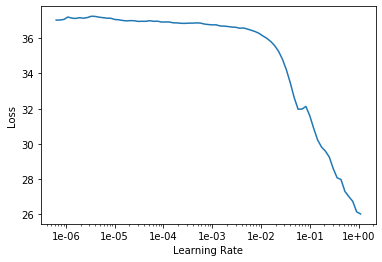

In [30]:
# Stworzenie modelu
learn = tabular_learner(data, layers=[1000,100], metrics=rmse)

# wynieramy odpowiednią ocene uczenia
learn.lr_find()

# zwykle znajdujemy punkt, w którym nachylenie jest najbardziej strome
learn.recorder.plot()

# Dopasuj model w oparciu o wybraną learning rate
learn.fit_one_cycle(10, max_lr =1e-03)

In [31]:
# Predykcja
preds, targets = learn.get_preds(DatasetType.Test)
labels = [np.exp(p[0].data.item()) for p in preds]

# create submission file to submit in Kaggle competition
wynik = pd.DataFrame({'Rzeczywistość': test_id, 'Test': labels})

wynik.head()

Rzeczywistość        Test
10          499.0  466.175533
11          670.0  729.207990
13          299.9  254.433284
19          580.0  534.052534
21          369.0  378.540898